### Constants ###

In [49]:
fat_without = 0.4 #proportion of people dying without treatment
t_fat_without = 0.9 #time in weeks until death without treatment
t_rec_without = 2.5 #time in weeks until recovery without treatment

fat_with = 0.35 #proportion of people dying with treatment
t_fat_with = 1 #time in weeks until death with treatment
t_rec_with = 1.56 #time in weeks until recovery with treatment
safe_b_rate =0.73 #proportion of burials that are conducted safely

### Uncertain Variables Ranges ###


In [92]:
I0_range = [60, 100, 2.5]

### Classes ###

In [100]:
import random
#TO-DO: This class only works for variables that have a constant ground truth (or one that doesn't change significantly).
# Otherwise the original range would no longer be in proportion to the value
class Uncertain_Constant:
    def __init__(self, ground_truth, variable_range):
        self.ground_truth = ground_truth
        self.variable_range = variable_range  #[value, value]
        self.original_range = original_range
        self.percentage = 1.0
        
        
        
    def fuzzifier(self):
        new_width = (self.original_range[1] - self.original_range[0]) * self.percentage
        in_current_range = False
        while in_current_range == False:
            z = new_width * random.uniform(0,1)
            new_range = [self.ground_truth - (new_width - z), self.ground_truth + z]
            if new_range[0] >= self.variable_range[0] and new_range[1] <= self_variable_range[1]:
                self.variable_range = new_range
                in_current_range = True
                
    def reduce_uncertainty(self, percentage):
        self.percentage = percentage
        self.fuzzifier()

class Uncertain_Variable:
    def __init__(self, ground_truth, variable_width):
        self.ground_truth = ground_truth
        self.variable_width = variable_width
        self.percentage = 1.0
        self.current_range =0
        
        self.fuzzifier()
        
    def fuzzifier(self):
        new_range_width = self.variable_width * self.percentage * self.ground_truth
        valid_range = False
        while valid_range == False:
            z = new_range_width * random.uniform(0,1)
            new_range  = [self.ground_truth - (new_range_width - z), self.ground_truth + z]

            if new_range[0] >= 0:
                self.current_range = new_range
                valid_range = True
                
    def reduce_uncertainty(self, percentage):
        self.percentage = percentage
        self.fuzzifier()
        
    def new_truth(self, ground_truth):
        self.ground_truth = ground_truth
        self.fuzzifier()
        
       

In [81]:
infected_folks = Uncertain_Variable(66, 2.5)
infected_folks.reduce_uncertainty(0.8)
infected_folks.new_truth(88)
print(infected_folks.ground_truth)

[-54.74879681005922, 110.25120318994078]
[-81.50480757100684, 83.49519242899318]
[-48.08045600795988, 116.91954399204012]
[-46.9231810992419, 118.0768189007581]
[-73.60962442388868, 91.39037557611132]
[-23.52546839947948, 141.47453160052052]
[-35.58963657835834, 129.41036342164165]
[-72.77717486513194, 92.22282513486805]
[45.662088422644075, 210.66208842264408]
[28.365265351072736, 160.36526535107274]
[44.903984241618446, 220.90398424161845]
88


### Helper functions

In [101]:
### Helper functions for the Compartmental Model ###

#change in susceptible people
def f_dsdt(susceptible, infected, deceased, beta_i, beta_d):
    return -(beta_i*infected + beta_d*deceased) * (susceptible /(susceptible + infected))

#change in recovered people
def f_drdt(infected, tr3r):
    return ((1-fat_without)*infected) / t_rec_without + tr3r / (t_rec_with/3)

#change in infected people
def f_didt(susceptible, infected, deceased, treated, beta_i, beta_d, ETC_cap):
    if treated < ETC_cap:
        return ((beta_i*infected + beta_d*deceased) * (susceptible /(susceptible + infected))
            - ((1 - fat_without)*infected) / t_rec_without
           - fat_without*infected / t_fat_without
            - min(ETC_cap - treated, infected)) 
    else:
       return ((beta_i*infected + beta_d*deceased) * (susceptible /(susceptible + infected))
            - ((1-fat_without)*infected) / t_rec_without
           - fat_without*infected / t_fat_without)

#change in treated people
#TO-DO: Something's going wrong: only ~28 people enter the ETC when it opens (instead of full capacity)
def f_dtr1dt(infected, tr1, treated, ETC_cap):
    if treated < ETC_cap:
        return min(ETC_cap - treated, infected) -(1-fat_with)*tr1 / (t_rec_with/3) - fat_with*tr1 / (t_fat_with/3)
    else:
        return -(1-fat_with)*tr1 / (t_rec_with/3) - fat_with*tr1/ (t_fat_with/3)

def f_dtr2f(tr1, tr2f):
    return (fat_with * tr1) / (t_fat_with/3) - tr2f / (t_fat_with/3)
    
def f_dtr3f(tr2f,tr3f):
    return tr2f / (t_fat_with/3) - tr3f / (t_fat_with/3)

def f_dtr2r(tr1, tr2r):
    return ((1-fat_with)* tr1) / (t_rec_with/3) - tr2r / (t_rec_with/3)

def f_dtr3r(tr2r, tr3r):
    return tr2r / (t_rec_with/3) - tr3r / (t_rec_with/3)
    
#change in deceased people
def f_dddt(infected, tr3f, deceased):
    return (fat_without*infected) / t_fat_without + (fat_with*tr3f) / t_fat_with - deceased * safe_b_rate 

def f_dfdt(deceased):
    return deceased * safe_b_rate

### Model Definition ###

In [114]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

def calc_population(y,t, beta_i, beta_d, safe_f, ETC_cap):
    susceptible, infected, recovered, deceased, funeral, tr1, tr2r, tr2f, tr3r, tr3f = y
    treated = tr1 + tr2r + tr2f + tr3r + tr3f

    
    dsdt = f_dsdt(susceptible, infected, deceased, beta_i, beta_d)
    didt = f_didt(susceptible, infected, deceased, treated, beta_i, beta_d, ETC_cap)
    drdt = f_drdt(infected, tr3r)
    dddt = f_dddt(infected, tr3f, deceased)
    dfdt = f_dfdt(deceased)
    dtr1dt = f_dtr1dt(infected, tr1, treated, ETC_cap)
    dtr2fdt = f_dtr2f(tr1, tr2f)
    dtr3fdt = f_dtr3f(tr2f,tr3f)
    dtr2rdt = f_dtr2r(tr1, tr2r)
    dtr3rdt = f_dtr3r(tr2r, tr3r)
    
    dydt = [dsdt, didt, drdt, dddt, dfdt, dtr1dt, dtr2rdt, dtr2fdt, dtr3rdt, dtr3fdt]
    return dydt


##Need to put a loop here that basically calls population for 1 timestep, then changes ETC_cap if necessary

def ebola_model(S0 = 4300000,
                I0 = 88,
                R0 = 0,
                D0 = 0,
                F0 = 0,
                T0 = 0,
                beta_i = 0.33,
                beta_d = 0.68,
                safe_f = 0.73,
                ETC_cap = 0):
    
    time_vec = np.linspace(0,1,2)
    
    I_uncertain = Uncertain_Variable(I0, I0_range[2])
    
    y0 = [S0, I_uncertain.ground_truth, R0, D0, F0, 0, 0, 0, 0, 0]
    
    S = []
    I = []
    R = []
    D = []
    F = []
    T = []
    
    for x in range (0,20):
                                                                                          
        population = odeint(calc_population, y0, t=time_vec, args=(beta_i, beta_d, safe_f, ETC_cap))
        
        #grab the states of the compartments at the end of the timestep
        y0 = population.T[:,1]

        
        #need to store the outcomes for each timestep
        S.append(y0[0])
        I.append(y0[1])
        I_uncertain.new_truth(y0[1])
        R.append(y0[2])
        D.append(y0[3])
        F.append(y0[4])
        T.append(y0[5]+y0[6]+y0[7]+y0[8]+y0[9])
        
        ###VISIBLE TO DM: S0, I in the form of the uncertainty object, beta in the form of the uncertainty opbject, T
        knowledge = I_uncertain.current_range

        if(knowledge[0] >= 100):
            ETC_cap = 50
        
        
    return S,I,R,D,F,T

### Model Initialisation ###

In [115]:
from ema_workbench import Model, IntegerParameter, TimeSeriesOutcome

model = Model('Ebola', function=ebola_model)



model.uncertainties = [IntegerParameter('I0', I0_range[0], I0_range[1])]

model.outcomes = [TimeSeriesOutcome('S'),
                  TimeSeriesOutcome('I'),
                  TimeSeriesOutcome('R'),
                  TimeSeriesOutcome('D'),
                  TimeSeriesOutcome('F'),
                  TimeSeriesOutcome('T')]

### Running the Model ###

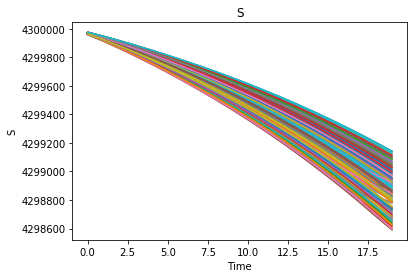

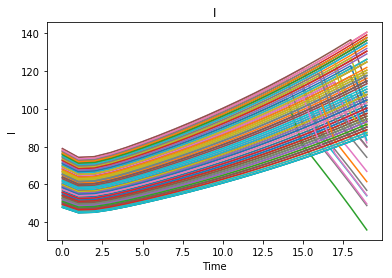

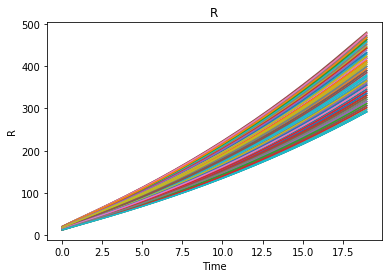

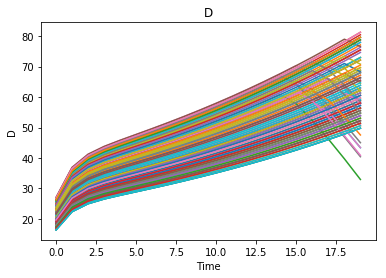

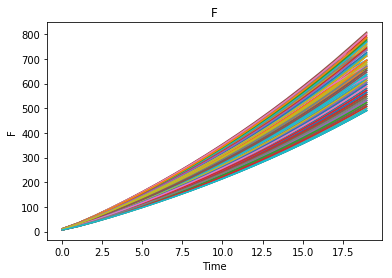

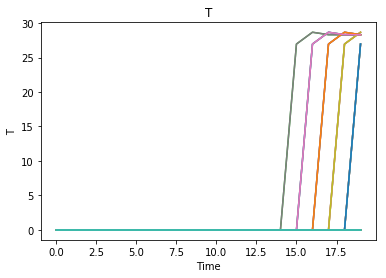

In [116]:
from ema_workbench import SequentialEvaluator

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=100)
    
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes.keys():
    plotting.lines((experiments, outcomes), outcomes_to_show=outcome, 
                   density=False)
plt.show()